## Projecting capital stock values (2010-2100) according to Dellink et al. (2017)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import warnings
from itertools import product as lstprod
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from dask_gateway import Gateway
from scipy.optimize import minimize as opt_min
from tqdm.auto import tqdm

from sliiders import country_level_ypk as ypk_fn
from sliiders import settings as sset

# dask gateway setup
gateway = Gateway()
cluster_name = sset.DASK_IMAGE

## Capital projection

We incorporate historical 2010 capital stock values and projected GDP, GDPpc, and population values.

### Importing and merging capital 2010 values

In [3]:
## historical data and projected gdp, gdppc, and population
hist_df = pd.read_parquet(
    sset.DIR_YPK_FINAL / "gdp_gdppc_pop_capital_1950_2020.parquet"
)
proj_yp_df = pd.read_parquet(
    sset.DIR_YPK_INT / "gdp_gdppc_pop_proj_2010_2100_post_ypk6.parquet"
)

## merging 2010 capital values
proj_ypk_df = proj_yp_df.merge(
    (
        hist_df.loc[(slice(None), 2010), ["rnna_19"]].rename(
            columns={"rnna_19": "capital"}
        )
    ),
    how="left",
    left_index=True,
    right_index=True,
)

### Getting the overall GDP elasticity with respect to capital

We first need to calculate the overall GDP elasticity w.r.t. capital, and here we assume a simple Cobb-Douglas production function with population being an approximation of the labor force. Alternatively, we may use IIASA approximation (from Crespo Cuaresma, 2017) of the said elasticity being approximately 0.326.

In [4]:
## let us subset values for 2010
k2010 = proj_ypk_df.loc[(slice(None), 2010), :]

## since 2010 values are same across all SSP (but could be different across iams)
## we subset SSP2 here and calculate the GDP elasticity wrt capital
k2010_pos_y = k2010.loc[
    (k2010.gdp > 0) & (k2010.index.get_level_values("ssp") == "SSP2"), :
].sort_index()
overall_elas_ols = sm.OLS(
    np.log(k2010_pos_y["gdp"]), sm.add_constant(np.log(k2010_pos_y[["pop", "capital"]]))
)
overall_elas_ols = overall_elas_ols.fit()

OVERALL_E = overall_elas_ols.params["capital"]
OVERALL_E_IIASA = 0.326

In [5]:
overall_elas_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     5117.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:08:35   Log-Likelihood:                -491.01
No. Observations:                 488   AIC:                             988.0
Df Residuals:                     485   BIC:                             1001.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1673      0.223      9.719      0.000       1.729       2.605
pop            0.3300      0.021     15.489      0.000       0.288       0.372
capital        0.6525      0.021     31.520      0.000       0.612       0.693
==============================================================================
Omnibus:                       34.453   Durbin-Watson:                   1.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.194
Skew:                          -0.318   Prob(JB):                     1.58e-20
Kurtosis:                       5.020   Cond. No.                         88.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Calculating the initial marginal product of capital (${MPK}_{r, t_0}$, with $t_0 = 2010$) and appending other necessary information

**Four options of calculating MPK**

If we assume a simple, Cobb-Douglas form for the production function (i.e., $Y = AK^\alpha L^{1-\alpha}$), the marginal product of capital (MPK) can be written as:
$$ \frac{\partial Y}{\partial K} = \alpha \cdot \underbrace{A{K}^\alpha{L}^{1-\alpha}}_{=Y}\cdot \frac{1}{K} = \alpha \frac{Y}{K} = \alpha \frac{Y/L}{K/L} $$
and similarly if we are going to assume some form like $Y = AK^\alpha$, we can write:
$$ \frac{\partial Y}{\partial K} = \alpha \cdot \underbrace{AK^{\alpha}}_{=Y} \cdot \frac{1}{K} = \alpha \frac{Y}{K} $$
so essentially the MPK can be written as the ratio of GDP ($Y$) and capital ($K$) multiplied by the GDP elasticity w.r.t. capital ($\alpha$).

We have acquired two different estimates (one ours, one IIASA's) of $\alpha$ from above, but we can further look at calculating $\alpha$ for each country by fitting either a Cobb-Douglas function or a capital-only function. So there are four options for calculating a country's MPK:
1. Use $\alpha$ from IIASA
2. Use $\alpha$ from our estimation
3. Use $\alpha$ from fitting a Cobb-Douglas function
4. Use $\alpha$ from fitting a capital-only function

and we can multiply the value of $\frac{Y}{K}$ (in the year 2010) afterwards.

In [6]:
def minimize_simple_production(x, K_values, Y_values):
    """Helper function for getting at the `A` (TFP) and `alpha` (GDP elasticity of
    capital). Returns the sum of squared errors with respect to actual GDP values.

    Parameters
    ----------
    x : array-like of floats
        divided into `A` (TFP) and `alpha` (GDP elasticity of capital)
    K_values : array-like of floats
        containing historical capital values (in the case of only-capital production
        functional form) or historical per-capita capital values (in the case of Cobb-
        Douglas functional form)
    Y_values : array-like of floats
        containing historical GDP values (in the case of only-capital production
        functional form) or historical per-capita GDP values (in the case of Cobb-
        Douglas functional form)

    Returns
    -------
    sse : float
        Sum of squared errors from netting the actual GDP values from estimated
        GDP values assuming a functional form

    """
    A, alpha = x

    diff = A * (K_values**alpha) - Y_values
    sse = np.sum(diff**2)

    return sse

In [7]:
def MPK_init_calc(
    ccode,
    hist_YKP=["rgdpna_19", "rnna_19", "pop"],
    base_YKP=["gdp", "capital", "pop"],
    hist_df=hist_df,
    base2010_df=k2010,
    init_A_alpha=[100, 1],
    alpha_overall=[OVERALL_E, OVERALL_E_IIASA],
):
    """Function for calculating the value of MPK (marginal product of capital) of the
    country specified by `ccode` and in the year specified by `year`.
    Parameters
    ----------
    ccode : str
        country code of the country we need to calculate the MPK for
    yr : int
        year we need to calculate the MPK for
    Yvar : str
        column name of the constant PPP GDP variable
    Kvar : str
        column name of the constant PPP capital stock variable
    Pvar : str
        column name of the population variable
    df : pandas.DataFrame
        DataFrame containing `Yvar`, `Kvar`, and `Pvar` as variables.
    init_A_alpha : array-like of floats
        points of initialization for `A` (TFP) and `alpha` (elasticity of GDP w.r.t.
        capital)
    alpha_overall : array-like of floats
        containing elasticities of GDP w.r.t. capital values that have been pre-
        calculated; two elements, the former being our own calculation of the elasticity
        and the latter being the elasticity calculated in Crespo Cuaresma (2017)

    Returns
    -------
    MPK_overall_our, MPK_overall_iiasa, MPK_country_pc, MPK_country : tuple of floats
        calculated MPKs using different versions of the GDP elasticity w.r.t. capital,
        first - using our self-calculated elasticity,
        second - using the Crespo Cuaresma (2017) elasticity,
        third - using the country-specific elasticity assuming Cobb-Douglass function,
        fourth - using the country-specific elasticity assuming capital-only function

    """

    ## Y, K, pop values of the years that we want to examine
    histccodes = hist_df.index.get_level_values("ccode").unique()
    if ccode in histccodes:
        YKP = hist_df.loc[ccode, hist_YKP].dropna()
        multthis = 1000000
        namelst = hist_YKP
    else:
        YKP = base2010_df.loc[
            base2010_df.index.get_level_values("ccode") == ccode, base_YKP
        ]
        YKP = YKP.loc[YKP.index.get_level_values("ssp") == "SSP1", :].copy()
        multthis = 1
        namelst = base_YKP
    Ys = YKP[namelst[0]].values * multthis
    Ks = YKP[namelst[1]].values * multthis
    Ps = YKP[namelst[2]].values * multthis

    yk_df = base2010_df.loc[
        base2010_df.index.get_level_values("ccode") == ccode, :
    ].copy()
    yk_df = yk_df.reset_index().set_index(["ccode", "ssp", "iam"])[base_YKP]
    yk_df["yk"] = yk_df[base_YKP[0]] / yk_df[base_YKP[1]]

    if (Ys == 0).all() or (Ks == 0).all() or (Ps == 0).all():
        yk_df["mpk_our"], yk_df["mpk_iiasa"] = 0, 0
        yk_df["mpk_ctry_cd"], yk_df["mpk_ctry_co"] = 0, 0
        return yk_df

    ## let us sort them in the order of Ks, just in case
    KYPs = np.array(sorted(zip(Ks, Ys, Ps)))
    Ks, Ys, Ps = KYPs[:, 0], KYPs[:, 1], KYPs[:, 2]

    ## optimizing values for A and alpha
    A_alpha_getter = lambda x: minimize_simple_production(x, Ks, Ys)
    A, alpha = opt_min(
        A_alpha_getter, init_A_alpha, bounds=((0, np.inf), (0, np.inf))
    ).x

    A_alpha_getter = lambda x: minimize_simple_production(x, Ks / Ps, Ys / Ps)
    A_pc, alpha_pc = opt_min(
        A_alpha_getter, init_A_alpha, bounds=((0, np.inf), (0, np.inf))
    ).x

    ## Y/K ratios
    yk_df["mpk_our"] = alpha_overall[0] * yk_df["yk"]
    yk_df["mpk_iiasa"] = alpha_overall[-1] * yk_df["yk"]
    yk_df["mpk_ctry_cd"] = alpha_pc * yk_df["yk"]
    yk_df["mpk_ctry_co"] = alpha * yk_df["yk"]

    return yk_df

In [8]:
mpk_calc = []
for i in tqdm(k2010.index.get_level_values("ccode").unique()):
    lst_mpks = MPK_init_calc(i)
    mpk_calc.append(lst_mpks)
mpk_calc = pd.concat(mpk_calc, axis=0)

## there are some cases in which the TPK and elasticities per country are not
## found via optimization (minimization); in this case, we will clip it with
## the minimum MPK garnered either from `mpk_our`, `mpk_iiasa`, or itself (whichever
## is lesser yet above 0)
for i in ["mpk_ctry_cd", "mpk_ctry_co"]:
    cd_values = mpk_calc[["mpk_our", "mpk_iiasa", i]].values
    mpk_calc.loc[mpk_calc[i] == 0, i] = cd_values[cd_values > 0].min()

  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_6203/1231449848.py:27: RuntimeWarning: overflow encountered in power
  diff = A * (K_values ** alpha) - Y_values
/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_6203/1231449848.py:27: RuntimeWarning: invalid value encountered in multiply
  diff = A * (K_values ** alpha) - Y_values


### Using the perpetual inventory method (PIM) with the dynamic parameter equations specified in Dellink et al. (2017)

The method in Dellink et al. (2017) is basically a PIM, but its parameters are dynamic (and evolving on their own) so that they approach converge to specific long-term values. Below is (with `dask` parallelization) an application of the Dellink et al. (2017) methodology using the MPKs (in 4 different methods) we have calculated above for each country.

First, we load the 2010 historical values (some estimated) of capital stock into our projection dataset. Also, we calculate the by-country average depreciation rates (from PWT 10.0) and overall average (average of the by-country rates) rates (also from PWT 10.0) which are used in the PIM process. If a country is missing from the PWT 10.0 dataset, we will simply use the overall average depreciation rate for the country-specific values.

In [9]:
## importing the (initial) iy ratios in 2010
iy_org = hist_df.loc[(slice(None), [2010]), ["iy_ratio_fit", "delta"]]
iy_org = (
    iy_org.reset_index()
    .rename(columns={"delta": "delta_c", "iy_ratio_fit": "iy_ratio"})
    .drop(["year"], axis=1)
    .set_index(["ccode"])
)

## AFG has the average delta value
delta_overall = iy_org.loc["AFG", "delta_c"]

## merge this with the 2010 (starting point) dataset
mpk_calc = mpk_calc.merge(iy_org, left_index=True, right_index=True, how="left")
mpk_calc["delta"] = delta_overall
scenarios = list(lstprod(*[[f"SSP{x}" for x in range(1, 6)], ["IIASA", "OECD"]]))

In [10]:
def pim_single_ctry(
    ccode_df,
    yr_startend=[2010, 2100],
    alpha_overall=OVERALL_E,
    MPK_bar=0.1,
    gamma_MPK=0.985,
    gamma_I=0.98,
    scenarios=scenarios,
    MPK_init=mpk_calc,
    MPK_var="mpk_our",
    Yvar="gdp",
    Kvar="capital",
    iy_var="iy_ratio",
    depre_overall_var="delta",
    depre_ctry_var="delta_c",
):
    """Function for running the perpetual inventory method (PIM, as described in
    Dellink et al., 2017), for a specific country, for each SSP-IAM scenario.

    ----------
    ccode_df : pandas.DataFrame
        DataFrame containing country-specific information for conducting the by-country
        PIM process to acquire capital stock projections. Needs to contain `Yvar`,
        `Kvar`, with indices `ccode`, `year`, `ssp`, and `iam`.
    yr_startend : array-like of ints
        starting year and end year of projection
    alpha_overall : float
        elasticity of GDP w.r.t. capital, global and not country-specific
    MPK_bar : float
        long-term elasticity of GDP w.r.t. capital, value 0.1 taken from Dellink et al.
        (2017)
    gamma_MPK : float
        velocity of converging to long-term elasticity of GDP w.r.t. capital, value
        0.985 taken from Dellink et al. (2017)
    gamma_I : float
        velocity of converging to long-term investment-to-GDP ratio, value 0.98 taken
        from Dellink et al. (2017)
    scenarios : array-like of tuples of str
        array-like of tuples containing SSP and IAM (in that order) scenarios
    MPK_init : pandas.DataFrame
        DataFrame containing initial-year marginal product of capital. Also should
        contain depreciation rates; so should contain `MPK_var`, `depre_overall_var`,
        `iy_var`, and `depre_ctry_var` and with index `ccode`, `ssp`, and `iam`
    MPK_var : str
        column name for the initial-year marginal product of capital
    Yvar : str
        column name of the constant PPP GDP variable
    Kvar : str
        column name of the (initial-year) constant PPP capital stock variable
    iy_var : str
        column name of the (initial-year) investment-to-GDP variable
    depre_overall_var : str
        depreciation rate variable (over all countries)
    depre_ctry_var : str
        country-specific depreciation rate variable

    Returns
    -------
    ccode_df : pandas.DataFrame
        DataFrame containing the updated values of capital stock projection estimates

    """
    newvar = "{}_estim".format(Kvar)
    ccode = ccode_df.index.get_level_values("ccode").values[0]

    ## delta is same across all scenarios
    delta, delta_r = MPK_init.loc[
        (ccode, "SSP1", "OECD"), [depre_overall_var, depre_ctry_var]
    ].values

    ccode_df["MPK"], ccode_df["IY"] = np.nan, np.nan
    ccode_df[newvar], ccode_df["KY"] = np.nan, np.nan
    for yr in range(yr_startend[0], yr_startend[-1] + 1):
        for scen in scenarios:
            ## advancing MPK values annually
            ssp, iam = scen
            if yr == yr_startend[0]:
                MPK = MPK_init.loc[(ccode, ssp, iam), MPK_var]
            else:
                prev_MPK = ccode_df.loc[(ccode, yr - 1, ssp, iam), "MPK"]
                MPK = gamma_MPK * prev_MPK + (1 - gamma_MPK) * MPK_bar
            ccode_df.loc[(slice(None), yr, ssp, iam), "MPK"] = MPK
            ky_LT = alpha_overall / MPK

            ## year-to-year GDP growth rates
            if yr != yr_startend[-1]:
                g_Ys = ccode_df.loc[(ccode, [yr, yr + 1], ssp, iam), Yvar].values
                Y_yr = g_Ys[0]
            else:
                g_Ys = ccode_df.loc[(ccode, [yr - 1, yr], ssp, iam), Yvar].values
                Y_yr = g_Ys[1]
            g_Y = g_Ys[-1] / g_Ys[0] - 1

            ## long-run I-to-Y ratio
            iy_LT = (g_Y + delta) * ky_LT

            ## I-to-Y ratios time series
            if yr == yr_startend[0]:
                IY = MPK_init.loc[(ccode, ssp, iam), iy_var]
            else:
                prev_IY = ccode_df.loc[(ccode, yr - 1, ssp, iam), "IY"]
                IY = (gamma_I * prev_IY) + (1 - gamma_I) * iy_LT
            ccode_df.loc[(slice(None), yr, ssp, iam), "IY"] = IY

            ## Perpetual inventory method capital stock time series
            if yr == yr_startend[0]:
                K_yr = MPK_init.loc[(ccode, ssp, iam), Kvar]
            else:
                prev_K = ccode_df.loc[(ccode, yr - 1, ssp, iam), newvar]
                K_yr = (1 - delta_r) * prev_K + IY * Y_yr
            ccode_df.loc[(slice(None), yr, ssp, iam), newvar] = K_yr
            ccode_df.loc[(slice(None), yr, ssp, iam), "KY"] = K_yr / Y_yr

    return ccode_df

In [11]:
## cluster setup
N_CLUSTER = 20
cluster = gateway.new_cluster(worker_image=cluster_name, profile="micro")
client = cluster.get_client()
cluster.scale(N_CLUSTER)
cluster

In [12]:
## getting the ccodes and ccode-specific DFs necessary
ccodes_pos_y = (
    proj_ypk_df.loc[proj_ypk_df.gdp > 0, :].index.get_level_values("ccode").unique()
)
ccodes_dfs = [proj_ypk_df.loc[[cc], :].copy() for cc in ccodes_pos_y]

## uninhabited ones set aside
cc_dfs_uninh = proj_ypk_df.loc[
    ~proj_ypk_df.index.get_level_values("ccode").isin(ccodes_pos_y), :
].sort_index()

In [13]:
## Those using our own global elasticity of GDP w.r.t. capital stock
pim_lamb = lambda x: pim_single_ctry(x, MPK_var="mpk_our")
pim_dfs_our = client.map(pim_lamb, ccodes_dfs)
pim_dfs_our = client.gather(pim_dfs_our)
pim_dfs_our = pd.concat(pim_dfs_our, axis=0)
print("Step 1/6 done")

pim_lamb = lambda x: pim_single_ctry(x, MPK_var="mpk_ctry_cd")
pim_dfs_our_cd = client.map(pim_lamb, ccodes_dfs)
pim_dfs_our_cd = client.gather(pim_dfs_our_cd)
pim_dfs_our_cd = pd.concat(pim_dfs_our_cd, axis=0)
print("Step 2/6 done")

pim_lamb = lambda x: pim_single_ctry(x, MPK_var="mpk_ctry_co")
pim_dfs_our_co = client.map(pim_lamb, ccodes_dfs)
pim_dfs_our_co = client.gather(pim_dfs_our_co)
pim_dfs_our_co = pd.concat(pim_dfs_our_co, axis=0)
print("Step 3/6 done")

Step 1/6 done
Step 2/6 done
Step 3/6 done


In [14]:
## Those using IIASA's estimate of global elasticitiy of GDP w.r.t. capital stock
pim_lamb = lambda x: pim_single_ctry(
    x, alpha_overall=OVERALL_E_IIASA, MPK_var="mpk_iiasa"
)
pim_dfs_iiasa = client.map(pim_lamb, ccodes_dfs)
pim_dfs_iiasa = client.gather(pim_dfs_iiasa)
pim_dfs_iiasa = pd.concat(pim_dfs_iiasa, axis=0)
print("Step 4/6 done")

pim_lamb = lambda x: pim_single_ctry(
    x, alpha_overall=OVERALL_E_IIASA, MPK_var="mpk_ctry_cd"
)
pim_dfs_iiasa_cd = client.map(pim_lamb, ccodes_dfs)
pim_dfs_iiasa_cd = client.gather(pim_dfs_iiasa_cd)
pim_dfs_iiasa_cd = pd.concat(pim_dfs_iiasa_cd, axis=0)
print("Step 5/6 done")

pim_lamb = lambda x: pim_single_ctry(
    x, alpha_overall=OVERALL_E_IIASA, MPK_var="mpk_ctry_co"
)
pim_dfs_iiasa_co = client.map(pim_lamb, ccodes_dfs)
pim_dfs_iiasa_co = client.gather(pim_dfs_iiasa_co)
pim_dfs_iiasa_co = pd.concat(pim_dfs_iiasa_co, axis=0)
print("Step 6/6 done")

Step 4/6 done
Step 5/6 done
Step 6/6 done


In [21]:
# import time
# time.sleep(20)
cluster.scale(0)
client.close()
cluster.close()
cluster.shutdown()

### Checking against the Dellink et al. (2017)'s Figure 6 (capital intensity plots)

In [53]:
def examine_against_fig6(pim_df, intensity="KY", fig_size=(18, 9)):
    """
    Function to examine the estimated capital intensity (the variable `intensity` in the
    DataFrame `pim_df`) against the Dellink et al. (2017) output of the same variable
    for four countries Tanzania, India, China, and the United States (shown in Fig. 6 of
    the paper). Also calculates the SSE across own estimates and Dellink et al. (2017)'s
    numbers.

    Parameters
    ----------
    pim_df : pandas DataFrame
        containing the `intensity` variable; should have indices `ccode`, `year`,
        `ssp`, and `iam` (in that order)
    intensity : str
        capital intensity variable in `pim_df`
    fig_size : tuple of floats or ints
        to set the output figure size

    Returns
    -------
    None, but plots the capital intensity values and SSE presented in the title

    """

    FOUR_CTRIES = ["TZA", "IND", "CHN", "USA"]
    SSP = ["SSP{}".format(x) for x in range(5, 0, -1)]
    FIG_YRS = [2100, 2050, 2020]

    ## preparing the figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    which = np.arange(0.1, 15 * 0.5 + 0.1, 0.5)
    which = which + np.array(range(0, len(which))) * 0.1

    ## from Dellink et al. (2017); had to measure the figure with a ruler
    ky_cm = 3 / 6.525
    dellink_case = pd.DataFrame(
        list(lstprod(*[FOUR_CTRIES, FIG_YRS, SSP])), columns=["ccode", "year", "ssp"]
    )
    dellink_case[intensity] = np.nan
    dellink_case["year"] = dellink_case["year"].astype("int64")
    dellink_case.set_index(["ccode", "year", "ssp"], inplace=True)

    ## Values from Figure 6, in the order of SSP5 -> SSP1 and 2100, 2050, 2020
    TZN = [
        np.array([6.2, 4.45, 4.4]) * ky_cm,
        np.array([6.95, 6.1, 4.475]) * ky_cm,
        np.array([6.25, 5.675, 4.5]) * ky_cm,
        np.array([5.95, 5.175, 4.45]) * ky_cm,
        np.array([6.25, 4.65, 4.45]) * ky_cm,
    ]
    IND = [
        np.array([7.4, 5.7, 5.75]) * ky_cm,
        np.array([7.575, 6.7, 5.8]) * ky_cm,
        np.array([7.65, 7.45, 5.85]) * ky_cm,
        np.array([7.3, 6.525, 5.775]) * ky_cm,
        np.array([7.6, 5.95, 5.75]) * ky_cm,
    ]
    CHN = [
        np.array([9.9, 8.45, 6.35]) * ky_cm,
        np.array([10.25, 9.55, 6.475]) * ky_cm,
        np.array([9.8, 10.55, 6.525]) * ky_cm,
        np.array([9.6, 9.55, 6.45]) * ky_cm,
        np.array([10.45, 8.8, 6.4]) * ky_cm,
    ]
    USA = [
        np.array([6.25, 5.4, 5.05]) * ky_cm,
        np.array([6.75, 5.9, 5.1]) * ky_cm,
        np.array([7.275, 6.325, 5.15]) * ky_cm,
        np.array([6.9, 6.05, 5.1]) * ky_cm,
        np.array([6.65, 5.8, 5.1]) * ky_cm,
    ]
    for i, ct in enumerate([TZN, IND, CHN, USA]):
        ctry = FOUR_CTRIES[i]
        for j, row in enumerate(ct):
            ssp = SSP[j]
            dellink_case.loc[(ctry, FIG_YRS, ssp), intensity] = row

    labs = []
    for j, ssp in enumerate(SSP):
        labs += ["2100", "{}   2050".format(ssp), "2020"]

    ax1.set_yticks(which + 0.15)
    ax1.set_yticklabels(labs)
    dellink_vals = []
    for l, ctry in enumerate(FOUR_CTRIES):
        ctry_vals = []
        for ssp in SSP:
            ctry_vals += list(dellink_case.loc[(ctry, FIG_YRS, ssp), intensity].values)
        ax1.barh(which + l * 0.1, ctry_vals, height=0.1, label=ctry)
        dellink_vals += ctry_vals
    ax1.legend()
    ax1.set_title("Capital intensities for selected countries, Dellink et al. (2017)")

    ax2.set_yticks(which + 0.15)
    ax2.set_yticklabels(labs)
    our_vals = []
    for l, ctry in enumerate(FOUR_CTRIES):
        ctry_vals = []
        for ssp in SSP:
            ctry_vals += list(
                pim_df.loc[(ctry, FIG_YRS, ssp, "OECD"), intensity].values
            )
        ax2.barh(which + l * 0.1, ctry_vals, height=0.1, label=ctry)
        our_vals += ctry_vals
    mx = max(our_vals + dellink_vals)
    ax_set = np.linspace(0, np.ceil(mx), 5)
    sse = ((np.array(our_vals) - np.array(dellink_vals)) ** 2).sum()
    sser = round(sse, 3)

    ax1.set_xticks(ax_set)
    ax2.set_xticks(ax_set)

    ax2.legend()
    ax2.set_title("Capital intensities, our own replication using the OECD method")

    fig.suptitle("Comparison of capital intensities; SSE={}".format(sser), fontsize=12)
    fig.show()

    return sse

We examine our 6 options as below. After examination with the graph as well as the SSE values, it seems that the case utilizing by-country MPK, **capital-only** production function, and the IIASA overall MPK are the ones that perform the best, at least with the four countries whose information are available.

However, since the SSEs for the numbers are very similar between the two cases (varying only by **capital-and-labor** production versus **capital-only** production) and because capital-only one has been used previously to produce capital stock estimates, we will use estimates from `pim_dfs_iiasa_co` as our main capital stock estimates and those from `pim_dfs_iiasa_cd` as alternative estimates.

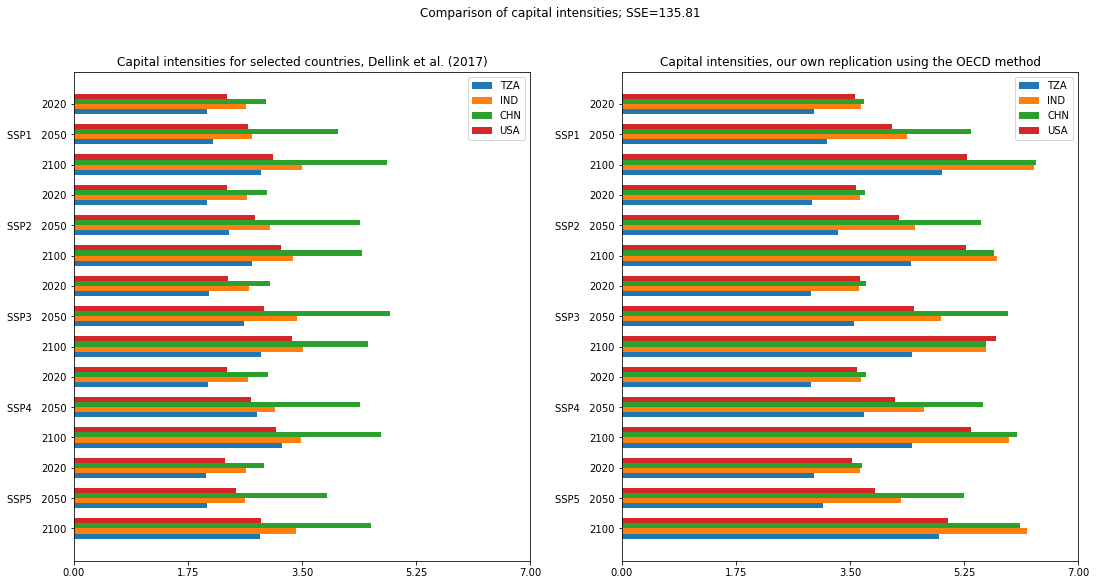

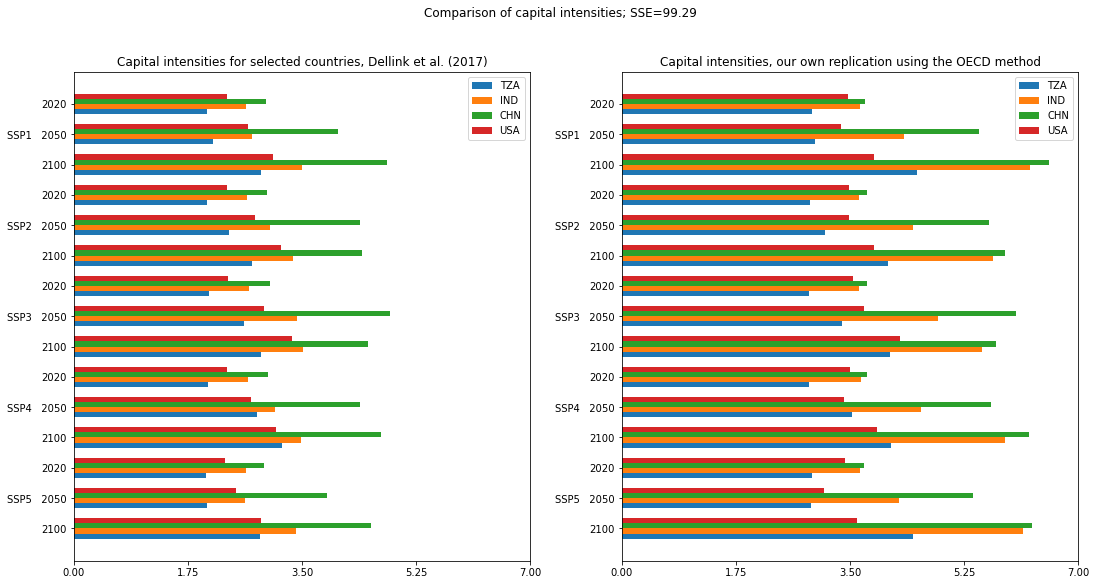

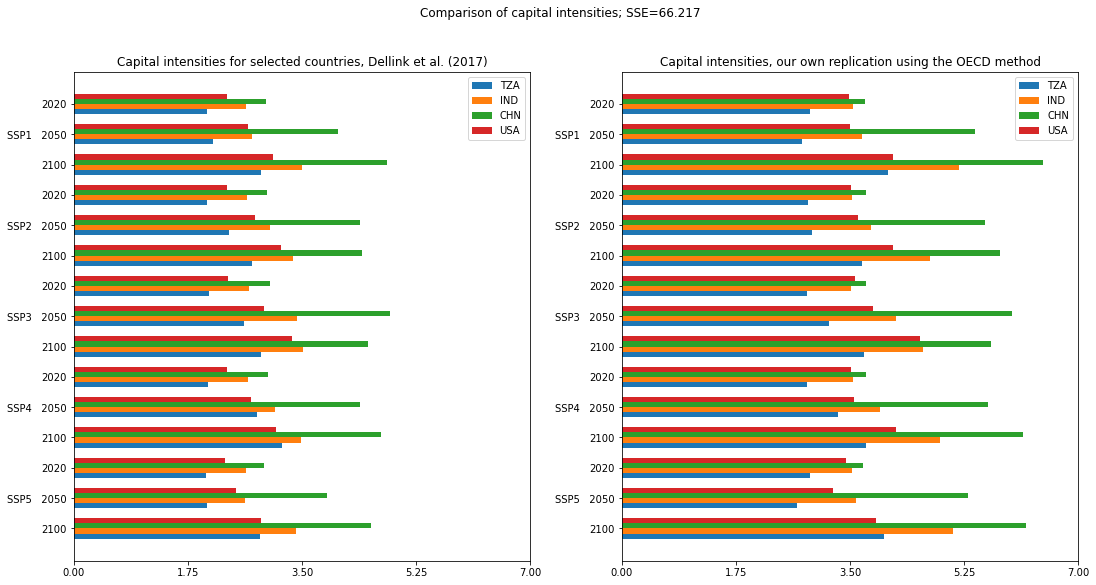

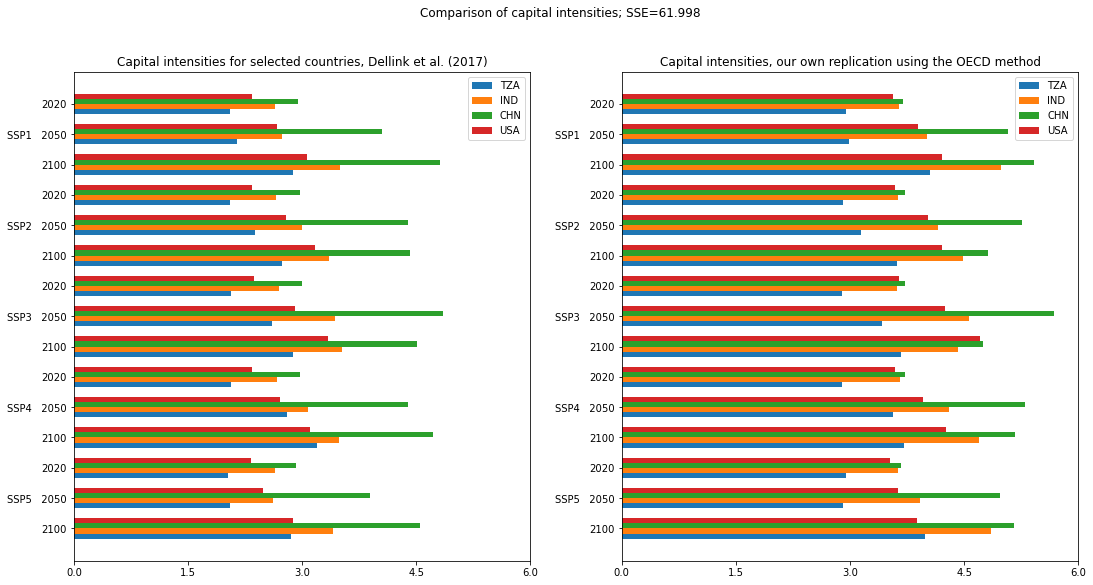

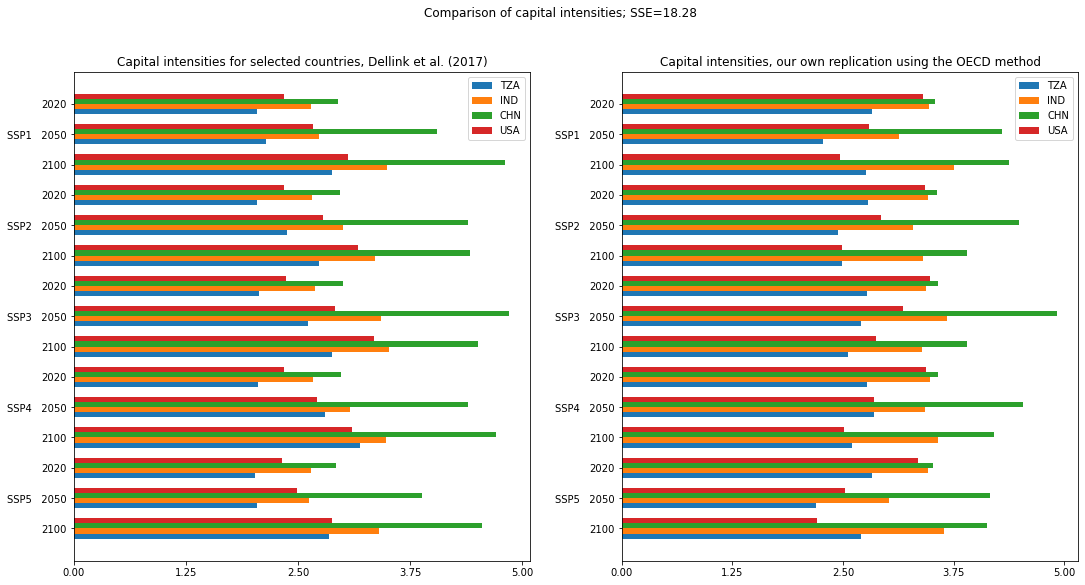

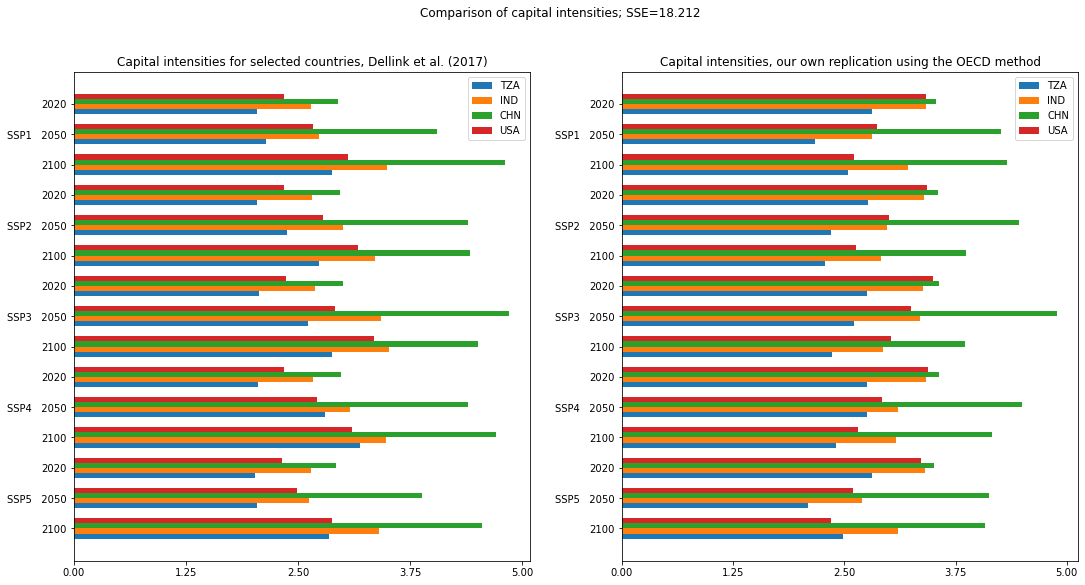

In [55]:
all_cases = [
    pim_dfs_our,
    pim_dfs_our_cd,
    pim_dfs_our_co,
    pim_dfs_iiasa,
    pim_dfs_iiasa_cd,
    pim_dfs_iiasa_co,
]
all_cases_sse = []
for i in all_cases:
    all_cases_sse.append(examine_against_fig6(i))

For sanity check, we will also graph top ten and bottom cases of capital stock (in natural logarithm) for some specified SSP (SSP3 below) and some year (2100 below).

In [56]:
def top_bottom_10(df=pim_dfs_iiasa_cd, yr=2100, ssp="SSP3", capvar="capital_estim"):
    """Shows the top ten and bottom ten according to `capvar` in the DataFrame `df`
    in the year `yr` and the SSP `ssp`; figures for IIASA and OECD IAMs are drawn
    separately.

    Parameters
    ----------
    df : pandas DataFrame
        containing `capvar` variable, with indices `ccode`, `year`,
        `ssp`, and `iam` (in that order)
    yr : int
        year in which we would like to compare the `capvar` values across countries
    ssp : str
        SSP scenario that we would like to examine
    capvar : str
        the name of the variable to produce top 10 and bottom 10 countries from

    Returns
    -------
    None, but presents the top 10 and bottom 10 countries by IAMs in bar graphs

    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))

    iiasa_df = df.loc[(slice(None), yr, ssp, "IIASA"), [capvar]].copy()
    iiasa_df.sort_values([capvar], inplace=True)
    iiasa_sma = iiasa_df.index.get_level_values("ccode")[0:10]
    iiasa_sma_vals = np.log(iiasa_df[capvar].values[0:10])

    small = list(range(1, 11))
    ax1.barh(small, iiasa_sma_vals, label="Bottom 10", color="orange", height=0.8)
    ax1.set_yticks(small)
    ax1.set_yticklabels(iiasa_sma)

    iiasa_big = iiasa_df.index.get_level_values("ccode")[-10:]
    iiasa_big_vals = np.log(iiasa_df[capvar].values[-10:])

    big = list(range(11, 21))
    ax1.barh(big, iiasa_big_vals, label="Top 10", color="#87CEEB", height=0.8)
    ax1.set_yticks(small + big)
    ax1.set_yticklabels(np.hstack([iiasa_sma, iiasa_big]))
    fig.suptitle("Log of capital stock in the year {} and {} scenario".format(yr, ssp))
    ax1.set_title("Case for IIASA")
    ax1.set_xlabel("Log of millions of dollars")

    oecd_df = df.loc[(slice(None), yr, ssp, "OECD"), [capvar]].copy()
    oecd_df.sort_values([capvar], inplace=True)
    oecd_sma = oecd_df.index.get_level_values("ccode")[0:10]
    oecd_sma_vals = np.log(oecd_df[capvar].values[0:10])

    ax2.barh(small, oecd_sma_vals, label="Bottom 10", color="orange", height=0.8)
    ax2.set_yticks(small)
    ax2.set_yticklabels(oecd_sma)

    oecd_big = oecd_df.index.get_level_values("ccode")[-10:]
    oecd_big_vals = np.log(oecd_df[capvar].values[-10:])

    ax2.barh(big, oecd_big_vals, label="Top 10", color="#87CEEB", height=0.8)
    ax2.set_yticks(small + big)
    ax2.set_yticklabels(np.hstack([oecd_sma, oecd_big]))
    ax2.set_title("Case for OECD")
    ax2.set_xlabel("Log of millions of dollars")

    fig.show()

    return None

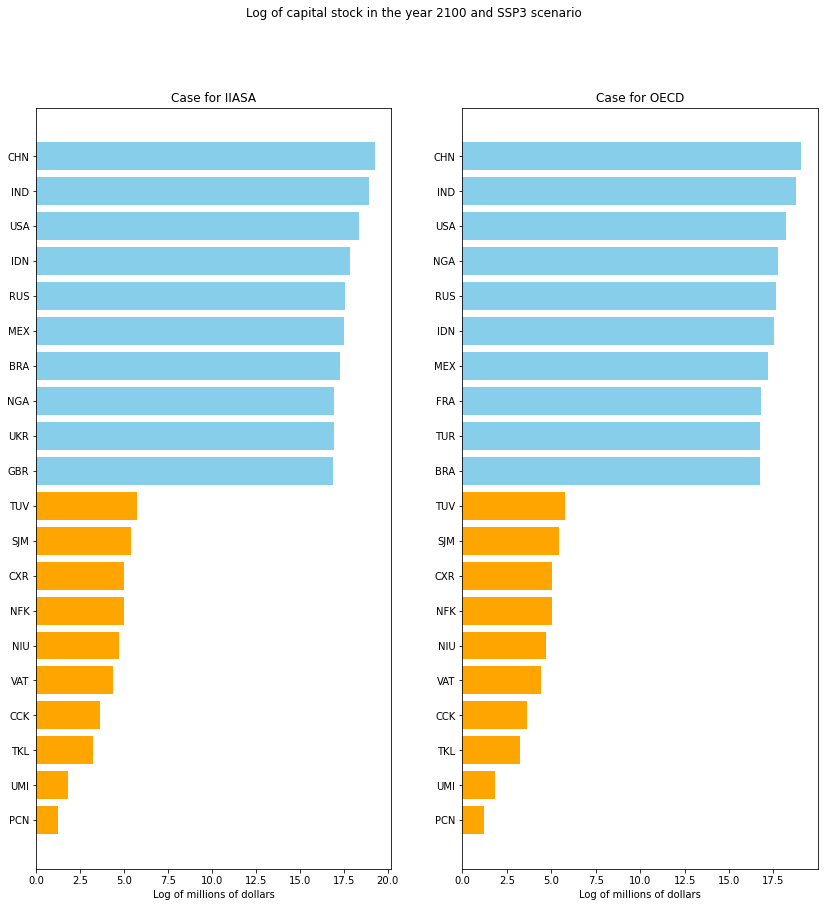

In [57]:
top_bottom_10(pim_dfs_iiasa_co)

In [58]:
## creating gdppc, and changing the name to be matched
output_df = proj_ypk_df.rename(
    columns={"gdp": "rgdpna_19", "gdppc": "rgdpna_pc_19"}
).drop(["capital"], axis=1)

## attaching the capital stock estimates
necess_cols = ["capital_estim", "MPK", "IY", "KY"]
output_df = output_df.merge(
    pim_dfs_iiasa_co[necess_cols].rename(columns={"capital_estim": "rnna_19"}),
    left_index=True,
    right_index=True,
    how="left",
)

alt_name = "rnna_19_alternative"
output_df = output_df.merge(
    pim_dfs_iiasa_cd[["capital_estim"]].rename(columns={"capital_estim": alt_name}),
    left_index=True,
    right_index=True,
    how="left",
)

for i in necess_cols[1:] + [alt_name, "rnna_19"]:
    output_df.loc[pd.isnull(output_df[i]), i] = 0

## adding the unit information and reordering
output_df["gdp_capital_unit"] = "millions (of USD)"
output_df["gdppc_unit"] = "ones (of USD)"
output_df["pop_unit"] = "millions (of people)"

col_ordering = [
    "gdp_capital_unit",
    "gdppc_unit",
    "pop_unit",
    "rgdpna_19",
    "rgdpna_pc_19",
    "rnna_19",
    "rnna_19_alternative",
    "pop",
    "MPK",
    "IY",
    "KY",
]
output_df = output_df[col_ordering].sort_index()

### Scale creation wrt. 2019 values of population and current-PPP (2019 USD) capital stock

In [59]:
## fetching the 2019 historical values
hist_gp = (
    hist_df.loc[(slice(None), 2019), ["cn_19", "pop"]]
    .reset_index()
    .drop(["year"], axis=1)
    .set_index(["ccode"])
    .rename(columns={"pop": "pop_2019", "cn_19": "cn_19_2019"})
)

## merge and create scales
output_df = output_df.merge(hist_gp, left_index=True, right_index=True, how="left")
output_df["pop_scale"] = output_df["pop"] / output_df["pop_2019"]
output_df["rnna_19_scale"] = output_df["rnna_19"] / output_df["cn_19_2019"]
output_df["rnna_19_alternative_scale"] = (
    output_df["rnna_19_alternative"] / output_df["cn_19_2019"]
)

### Exporting: historical 2019 values

In [61]:
hist2019 = hist_df.loc[
    (slice(None), 2019),
    [
        "gdp_capital_unit",
        "gdppc_unit",
        "pop_unit",
        "cgdpo_19",
        "cgdpo_pc_19",
        "pop",
        "cn_19",
    ],
].reset_index()
hist2019 = hist2019.drop(["year"], axis=1).set_index(["ccode"])
hist2019.to_parquet(sset.DIR_YPK_FINAL / "gdp_gdppc_pop_capital_hist2019.parquet")

### Exporting: projected values (2010-2100)

In [62]:
col_ordering = [
    "gdp_capital_unit",
    "gdppc_unit",
    "pop_unit",
    "rgdpna_19",
    "rgdpna_pc_19",
    "rnna_19",
    "rnna_19_scale",
    "rnna_19_alternative",
    "rnna_19_alternative_scale",
    "cn_19_2019",
    "pop",
    "pop_scale",
    "pop_2019",
    "MPK",
    "IY",
    "KY",
]

## filling in the nan's with 0, for uninhabited areas
output_df = output_df[col_ordering].copy().sort_index()
for i in ["rgdpna_pc_19", "rnna_19_scale", "rnna_19_alternative_scale", "pop_scale"]:
    output_df.loc[pd.isnull(output_df[i]), i] = 0

output_df.to_parquet(
    sset.DIR_YPK_FINAL / "gdp_gdppc_pop_capital_proj_2010_2100.parquet"
)